### Import dependencies

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

### Check if Tensorflow identifies the GPU succesfully and set GPU memory consumption growth

In [2]:
# grab all the gpus available in the machine
gpus = tf.config.experimental.list_physical_devices('GPU')
# check that tensorflow identifies your gpu
print(gpus)
# for every gpu set memory growth (making tensorflow to keep the memory only to what it needs)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 1) Define paths to data

In [3]:
down = os.path.join('data','down')
go = os.path.join('data','go')
left = os.path.join('data','left')
no = os.path.join('data','no')
right = os.path.join('data','right')
stop = os.path.join('data','stop')
up = os.path.join('data','up')
yes = os.path.join('data','yes')

### 2) Create Tensorflow datasets and label the data

In [4]:
def create_dataset_with_labels(class_path, label):
    files = tf.data.Dataset.list_files(class_path + '\*.wav')
    labeled_dataset = files.map(lambda x: (x, label))
    return labeled_dataset

# Create labeled datasets for each class with numeric labels
DOWN = create_dataset_with_labels(down, 1.0)
GO = create_dataset_with_labels(go, 2.0)
LEFT = create_dataset_with_labels(left, 3.0)
NO = create_dataset_with_labels(no, 4.0)
RIGHT = create_dataset_with_labels(right, 5.0)
STOP = create_dataset_with_labels(stop, 6.0)
UP = create_dataset_with_labels(up, 7.0)
YES = create_dataset_with_labels(yes, 8.0)

# Concatenate all datasets
data = DOWN.concatenate(GO).concatenate(LEFT).concatenate(NO).concatenate(RIGHT).concatenate(STOP).concatenate(UP).concatenate(YES)

### 3) Build dataloading function

In [5]:
def load_wav_16k_mono(filename):
    # load encoded wav file
    contents = tf.io.read_file(filename)

    # decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(contents, desired_channels=1)

    # remove trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    
    return wav

### 4) Build preprocessing function

In [6]:
def preprocess(file_path, label):
    # load data into it's wave form 
    wav = load_wav_16k_mono(file_path)

    # grab only the first 15000 examples from each of the signals
    wav = wav[:15000]

    # pad with zeros the examples that do not meet the 15000 requirement
    zero_padding = tf.zeros([15000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)

    # create a spectogram
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)

    # convert to an absolute set of values
    spectrogram = tf.abs(spectrogram)

    # encapsulate spectogram in a set of arrays
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

### 5) Test the function and visualize spectograms

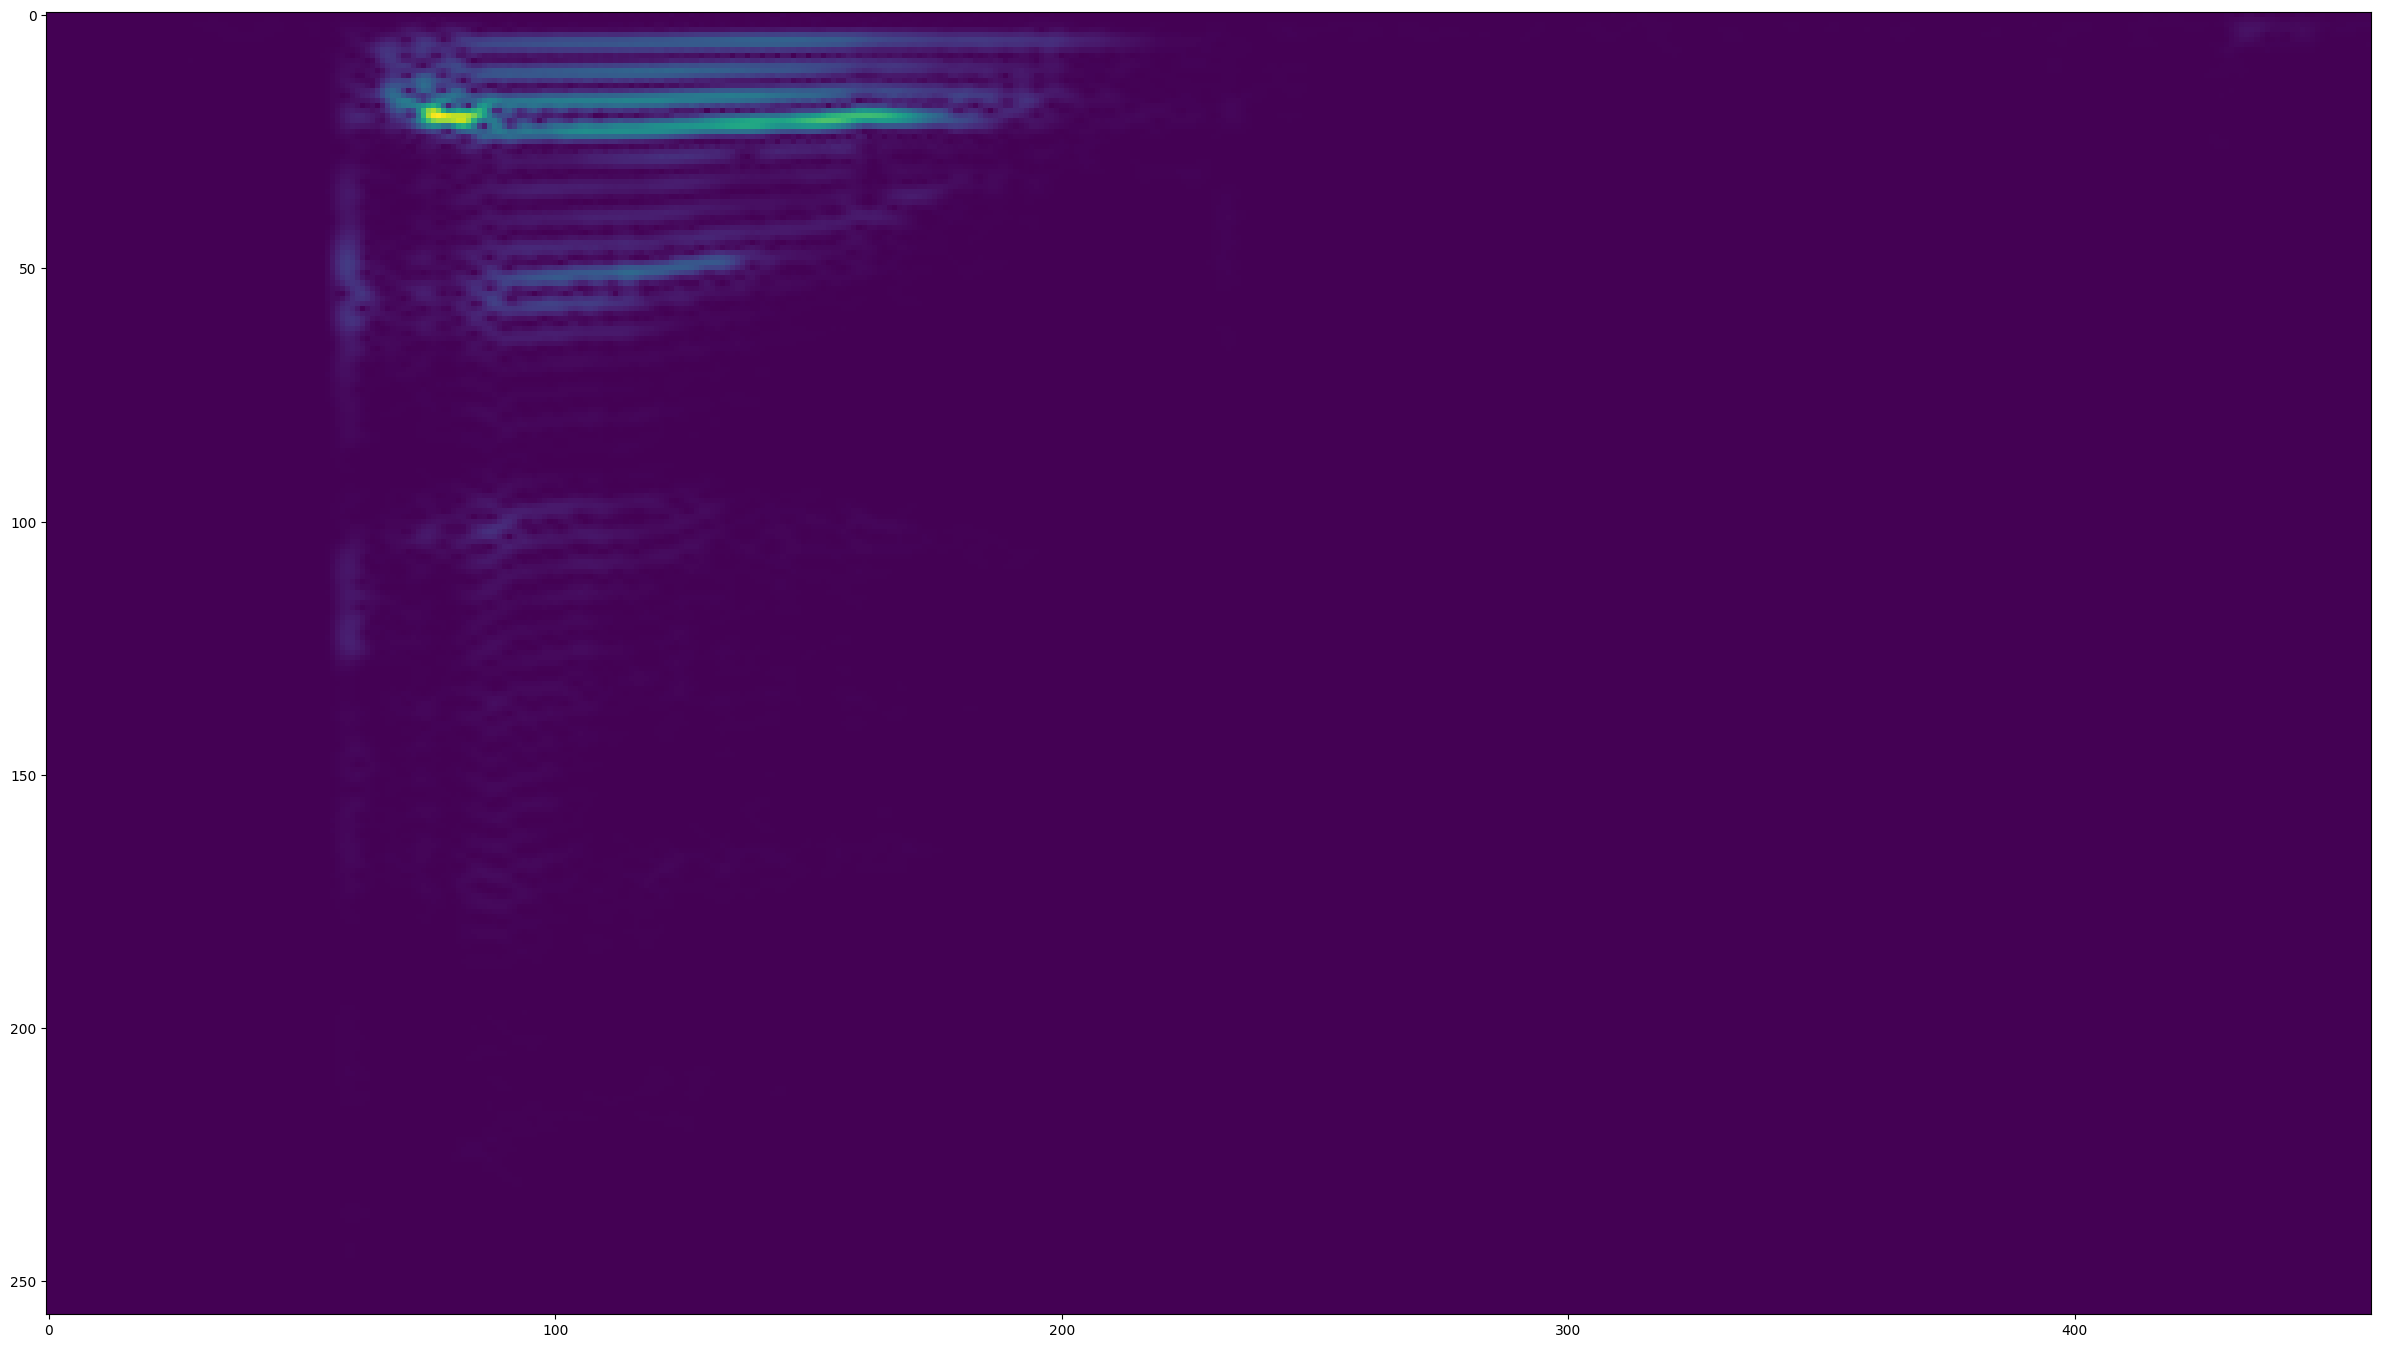

In [7]:
filepath, label = data.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectogram, label = preprocess(filepath, label)

plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

### 6) Create tensorflow data pipeline

In [8]:
# run all data through the preprocess function from above
data = data.map(preprocess)
# cache the data
data = data.cache()
# mix the data
data = data.shuffle(buffer_size=1000)
# batch the data in a size of 16 per batch
data = data.batch(16)
# prefetch 8 examples to eliminate any cpu bottlenecking
data = data.prefetch(8)

### 7) Split into training and testing partitions

In [ ]:
# 80% training
train = data.take(400)
# 20% testing
test = data.skip(400).take(100)